### Imports

In [1]:
import pandas as pd
import numpy as np
from pyhhmm.gaussian import GaussianHMM
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

In [2]:
# Boolean value
pnl = 0
max_pnl = 0
trade_side = 0
entry_price = None
max_drawdown = 0
take_profit = 1.5
stop_loss = 2
trade = False
entry_condition = None
initial_capital = 300
current_capital = 0

### Dados e Time Frames Alterados

In [3]:
# Extração de dados
hf = h5py.File("data/binance.h5")
existing_data = hf["BTCUSDT"][:]
data = sorted(existing_data, key=lambda x: x[0])
data = np.array(data)

df = pd.DataFrame(data, columns=["Date", "Open", "High", "Low", "Close", "Volume"])
df["Date"] = pd.to_datetime(df["Date"].values.astype(np.int64), unit="ms")
df.set_index("Date", drop=True, inplace=True)

In [4]:
# Reformula o Timeframe
TF_EQUIV = {"1m": "1Min", "5m": "5Min", "15m": "15Min", "30m": "30Min", "1h": "1H", "4h": "4H", "12h": "12H", "1d": "D"}
def resample_timeframe(data: pd.DataFrame, tf: str) -> pd.DataFrame:
    return data.resample(TF_EQUIV[tf]).agg(
        {"Open": "first", "High": "max", "Low": "min", "Close": "last", "Volume": "sum"})

In [5]:
data = resample_timeframe(df, '30m')
data = data[['Open','High','Low','Close']]
data

,Open,High,Low,Close
Date,,,,
2022-01-06 00:30:00,43646.18,43661.14,43594.54,43656.00
2022-01-06 01:00:00,43655.99,43766.00,43489.85,43576.40
2022-01-06 01:30:00,43577.27,43639.72,43290.47,43525.91
2022-01-06 02:00:00,43525.90,43600.00,43111.00,43226.14
2022-01-06 02:30:00,43225.97,43434.00,43192.83,43248.40
...,...,...,...,...
2023-01-12 17:30:00,18246.50,18920.00,18238.00,18840.00
2023-01-12 18:00:00,18840.00,19000.00,18634.50,18635.20
2023-01-12 18:30:00,18635.20,18827.10,18607.90,18790.00


In [6]:
df = data.copy()

In [7]:
# Adiciona os Moving Averages
df['MA_200 High'] = df['High'].rolling(window=200).mean()
df['MA_200 Low'] = df['Low'].rolling(window=200).mean()
df.head()

,Open,High,Low,Close,MA_200 High,MA_200 Low
Date,,,,,,
2022-01-06 00:30:00,43646.18,43661.14,43594.54,43656.00,NaN,NaN
2022-01-06 01:00:00,43655.99,43766.00,43489.85,43576.40,NaN,NaN
2022-01-06 01:30:00,43577.27,43639.72,43290.47,43525.91,NaN,NaN
2022-01-06 02:00:00,43525.90,43600.00,43111.00,43226.14,NaN,NaN
2022-01-06 02:30:00,43225.97,43434.00,43192.83,43248.40,NaN,NaN


In [8]:
# Adiciona o RSI e sua média móvel 

delta = df['Close'].diff()
rsi_length = 14
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

avg_gain = up.ewm(com=(rsi_length- 1), min_periods=rsi_length).mean()
avg_loss = down.abs().ewm(com=(rsi_length - 1), min_periods=rsi_length).mean()

rs = avg_gain / avg_loss

rsi = 100 - 100 / (1 + rs)
rsi = rsi.round(2)
df['RSI'] = rsi
df['MA_RSI']= rsi.rolling(14).mean()
df.tail(14)

,Open,High,Low,Close,MA_200 High,MA_200 Low,RSI,MA_RSI
Date,,,,,,,,
2023-01-12 13:00:00,18263.3,18350.0,18095.3,18178.9,17405.1100,17355.7255,60.61,67.233571
2023-01-12 13:30:00,18178.9,18377.4,17907.3,18277.6,17412.1970,17360.6700,67.83,67.252857
2023-01-12 14:00:00,18277.7,18348.8,18104.4,18142.7,17419.2865,17366.5555,53.42,66.205714
2023-01-12 14:30:00,18142.7,18157.5,17920.0,17989.7,17425.4160,17371.5195,42.41,64.559286
2023-01-12 15:00:00,17989.7,18132.9,17981.7,18072.5,17431.4145,17376.7850,48.59,63.420000
2023-01-12 15:30:00,18072.5,18123.0,18031.7,18077.7,17437.3655,17382.3545,48.96,62.195000
2023-01-12 16:00:00,18077.6,18137.4,18045.7,18125.1,17443.4400,17387.9980,52.33,61.188571
2023-01-12 16:30:00,18125.1,18130.9,18085.5,18128.3,17449.4840,17393.8490,52.55,60.147143
2023-01-12 17:00:00,18128.4,18262.8,18096.4,18245.0,17456.1505,17399.7675,60.05,59.582857


In [9]:
# ADX
period = 14
alpha = 1 / period
adx_ma_length = 12

# TR
df['H-L'] = df['High'] - df['Low']
df['H-C'] = np.abs(df['High'] - df['Close'].shift(1))
df['L-C'] = np.abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
del df['H-L'], df['H-C'], df['L-C']

# ATR
df['ATR'] = df['TR'].ewm(alpha=alpha, adjust=False).mean()

# +-DX
df['H-pH'] = df['High'] - df['High'].shift(1)
df['pL-L'] = df['Low'].shift(1) - df['Low']
df['+DX'] = np.where(
    (df['H-pH'] > df['pL-L']) & (df['H-pH'] > 0),
    df['H-pH'],
    0.0
)
df['-DX'] = np.where(
    (df['H-pH'] < df['pL-L']) & (df['pL-L'] > 0),
    df['pL-L'],
    0.0
)
del df['H-pH'], df['pL-L']

# +- DMI
df['S+DM'] = df['+DX'].ewm(alpha=alpha, adjust=False).mean()
df['S-DM'] = df['-DX'].ewm(alpha=alpha, adjust=False).mean()
df['+DMI'] = (df['S+DM'] / df['ATR']) * 100
df['-DMI'] = (df['S-DM'] / df['ATR']) * 100
del df['S+DM'], df['S-DM']

# ADX
df['DX'] = (np.abs(df['+DMI'] - df['-DMI']) / (df['+DMI'] + df['-DMI'])) * 100
df['ADX'] = df['DX'].ewm(alpha=alpha, adjust=False).mean()
del df['DX'], df['ATR'], df['TR'], df['-DX'], df['+DX'], df['+DMI'], df['-DMI']
df['MA_ADX'] = df['ADX'].rolling(adx_ma_length).mean()
df

,Open,High,Low,Close,MA_200 High,MA_200 Low,RSI,MA_RSI,ADX,MA_ADX
Date,,,,,,,,,,
2022-01-06 00:30:00,43646.18,43661.14,43594.54,43656.00,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06 01:00:00,43655.99,43766.00,43489.85,43576.40,NaN,NaN,NaN,NaN,100.000000,NaN
2022-01-06 01:30:00,43577.27,43639.72,43290.47,43525.91,NaN,NaN,NaN,NaN,95.312553,NaN
2022-01-06 02:00:00,43525.90,43600.00,43111.00,43226.14,NaN,NaN,NaN,NaN,92.808742,NaN
2022-01-06 02:30:00,43225.97,43434.00,43192.83,43248.40,NaN,NaN,NaN,NaN,90.483775,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-01-12 17:30:00,18246.50,18920.00,18238.00,18840.00,17466.1085,17406.3460,78.60,60.295714,35.293400,41.644965
2023-01-12 18:00:00,18840.00,19000.00,18634.50,18635.20,17476.4360,17414.8985,67.06,60.343571,37.026532,40.704356
2023-01-12 18:30:00,18635.20,18827.10,18607.90,18790.00,17485.8315,17423.2680,70.58,60.477857,38.378347,39.855942


In [10]:
df.dropna(inplace=True)
df

,Open,High,Low,Close,MA_200 High,MA_200 Low,RSI,MA_RSI,ADX,MA_ADX
Date,,,,,,,,,,
2022-01-10 04:00:00,41946.05,42151.56,41904.49,42100.00,42299.12110,41987.00190,54.23,49.093571,11.696143,13.989139
2022-01-10 04:30:00,42100.00,42219.84,42058.00,42164.36,42291.91460,41979.31920,56.01,49.028571,12.381795,13.634592
2022-01-10 05:00:00,42165.05,42198.53,42078.73,42086.02,42284.07725,41972.26360,53.30,48.577143,13.018471,13.365728
2022-01-10 05:30:00,42086.01,42095.95,41942.54,42006.00,42276.35840,41965.52395,50.61,48.389286,12.702342,13.098843
2022-01-10 06:00:00,42006.01,42013.85,41801.63,41940.34,42268.42765,41958.97710,48.44,48.670000,11.991801,12.833363
...,...,...,...,...,...,...,...,...,...,...
2023-01-12 17:30:00,18246.50,18920.00,18238.00,18840.00,17466.10850,17406.34600,78.60,60.295714,35.293400,41.644965
2023-01-12 18:00:00,18840.00,19000.00,18634.50,18635.20,17476.43600,17414.89850,67.06,60.343571,37.026532,40.704356
2023-01-12 18:30:00,18635.20,18827.10,18607.90,18790.00,17485.83150,17423.26800,70.58,60.477857,38.378347,39.855942


In [11]:
# Sinal de Trade
df.loc[(df['Close'] > df['MA_200 High']) & (df['ADX'] > 31) & (df['RSI'] > 74) & (df['MA_RSI'] < df['RSI']) & (df['MA_ADX'] < df['ADX']), 'Signal'] = 1
df.loc[(df['Close'] < df['MA_200 Low']) & (df['ADX'] > 31) & (df['RSI'] < 30) & (df['MA_RSI'] > df['RSI']) & (df['MA_ADX'] < df['ADX']), 'Signal'] = -1
df['Signal'].fillna(0, inplace=True)
df['Signal'] = df['Signal'].shift(1)
df['Entry Price'] = 0
df['Close Price'] = 0
# df['PNL'] = 0
# df['True Table'] = None

In [12]:
trade_list = list()
close_price_list = list()
pnl_list = list()
win_rate = 0
loss_rate = 0

In [13]:
# Condição de entrada
for i in range(len(df['Close'])):
    if df['Signal'][i] in [1, -1] and trade is False:
        entry_price = df['Open'][i]
        if df['Signal'][i] == 1:
            trade_side = 1
            trade = True
            
        elif df['Signal'][i] == -1:
            trade_side = -1
            trade = True            
    # Check PNL
    if trade_side == 1:
        if df["High"][i] >= entry_price * (1 + take_profit / 100):
            pnl += take_profit
            initial_capital += initial_capital * (take_profit / 100)
            trade_list.append(entry_price)
            close_price_list.append(df['Close'][i])
            trade = False
            trade_side = 0
            entry_price = None
            pnl_list.append(round(pnl, 2))
            win_rate += 1
        elif df["Low"][i] <= entry_price * (1 - stop_loss / 100):
            pnl -= stop_loss
            initial_capital -= initial_capital * (stop_loss / 100)
            trade_list.append(entry_price)
            close_price_list.append(df['Close'][i])
            trade = False
            trade_side = 0
            entry_price = None
            pnl_list.append(round(pnl, 2))
            loss_rate += 1
    elif trade_side == -1:
        if df["Low"][i] <= entry_price * (1 - take_profit / 100):
            pnl += take_profit
            initial_capital += initial_capital * (take_profit / 100)
            trade_list.append(entry_price)
            close_price_list.append(df['Close'][i])
            trade = False
            trade_side = 0
            entry_price = None
            pnl_list.append(round(pnl, 2))
            win_rate += 1
        elif df["High"][i] >= entry_price * (1 + stop_loss / 100):
            pnl -= stop_loss
            initial_capital -= initial_capital * (stop_loss / 100)
            trade_list.append(entry_price)
            close_price_list.append(df['Close'][i])
            trade = False
            trade_side = 0
            entry_price = None
            pnl_list.append(round(pnl, 2))
            loss_rate += 1
            
            
    max_pnl = max(max_pnl, pnl)
    max_drawdown = max(max_drawdown, max_pnl - pnl)

print(f'PNL: {round(((initial_capital-300)/300)*100, 2)}%\nDrawdown: {max_drawdown}%')
print('--------------------------------------')
print(f'Gain Capital: {round(initial_capital - 300, 2)}')
print('--------------------------------------')
print(f'Win rate: {round((win_rate/len(pnl_list)*100), 2)}%')
print('--------------------------------------')
print(f'Loss rate: {round((loss_rate/len(pnl_list)*100), 2)}%')

PNL: 187.88%
Drawdown: 10.0%
--------------------------------------
Gain Capital: 563.63
--------------------------------------
Win rate: 68.77%
--------------------------------------
Loss rate: 31.23%


In [14]:
pnl_df = pd.DataFrame(columns=['Entry Price', 'Close Price','PNL'])
pnl_df['Entry Price'] = trade_list
pnl_df['Close Price'] = close_price_list
pnl_df['PNL'] = pnl_list
pnl_df

,Entry Price,Close Price,PNL
0,43357.15,43881.76,1.5
1,43881.77,43170.00,-0.5
2,41888.72,42945.09,-2.5
3,42055.50,41780.00,-1.0
4,43257.23,41319.68,-3.0
...,...,...,...
264,16731.50,17042.70,103.5
265,17124.60,17367.40,105.0
266,17642.50,17935.70,106.5
267,17935.60,18264.00,108.0


In [15]:
'''print(trade_list)
print()
print(close_price_list)
print()
print(len(trade_list))
print(len(close_price_list))
print(len(pnl_list))'''

'print(trade_list)\nprint()\nprint(close_price_list)\nprint()\nprint(len(trade_list))\nprint(len(close_price_list))\nprint(len(pnl_list))'

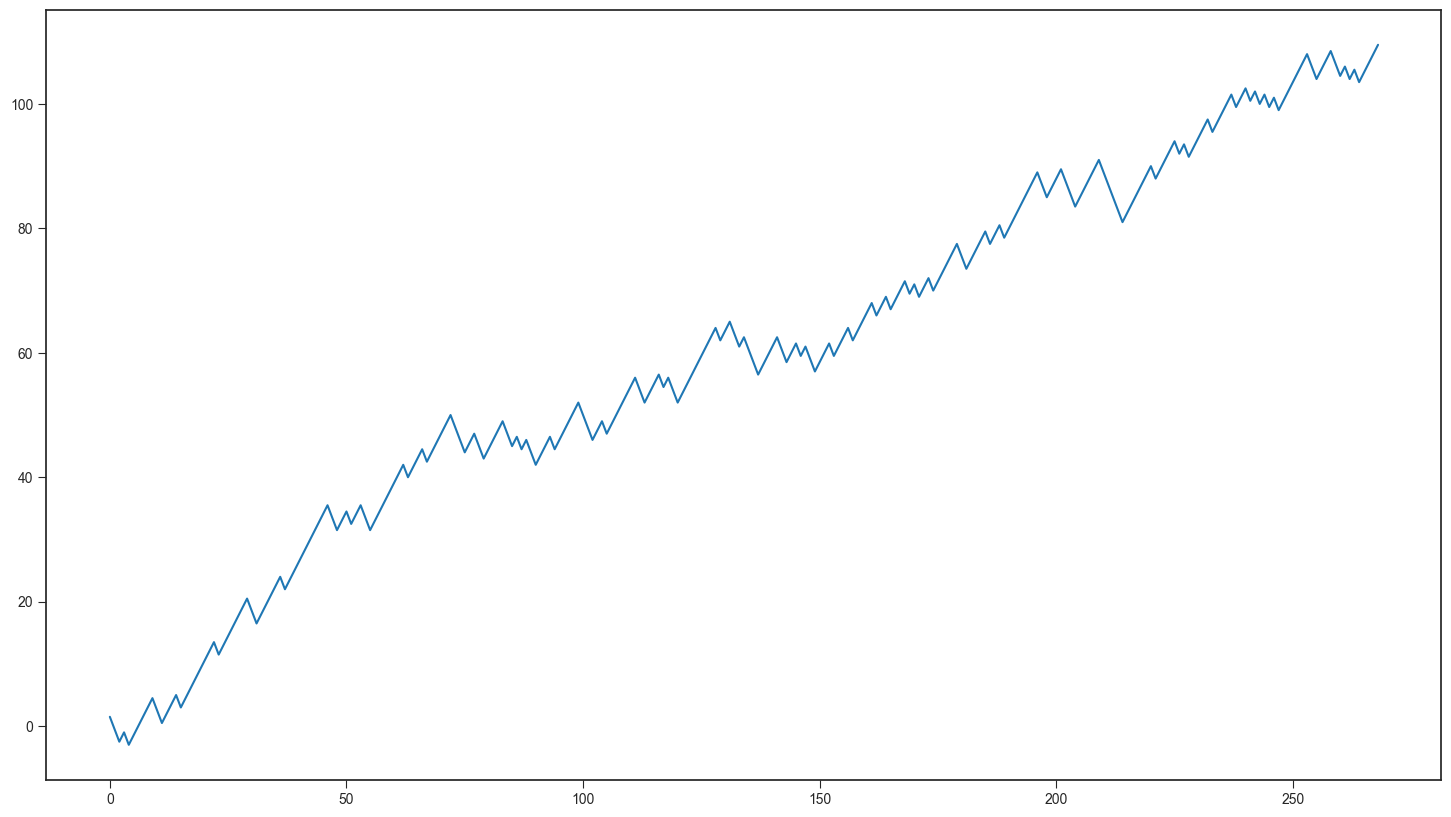

In [16]:
# Resultados
fig = plt.figure(figsize=(18,10))
plt.plot(pnl_list)
plt.show()

In [17]:
pnl = 0
max_pnl = 0
max_drawdown = 0
pnl_list.clear()
trade_list.clear()
close_price_list.clear()
initial_capital = 300
win_rate = 0
loss_rate = 0